In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from typing import Dict, Tuple, List, Any
from IPython.display import display


### Codigo (no se tiene que modificar ni nada)

In [23]:

def calculate_minimum_punishment(N: int, A: int, R: float) -> float:
    """
    Calculate the minimum punishment needed to discourage lying.
    
    Parameters:
    -----------
    N : int
        Total number of students
    A : int
        Number of students randomly selected for review
    R : float
        Reward for completing the assignment
        
    Returns:
    --------
    float
        Minimum punishment value needed (negative number)
    """
    p = A / N  # Probability of being reviewed
    # From the theory: C <= -((N-A)/A)*R
    C = -((N - A) / A) * R
    return C

def calculate_expected_utility(action: str, report: str, p: float, R: float, C: float) -> float:
    """
    Calculate the expected utility for a student given their actions and the game parameters.
    
    Parameters:
    -----------
    action : str
        'Do' if the student does the homework, 'Not' if they don't
    report : str
        'Yes' if the student reports they did the homework, 'No' if they report they didn't
    p : float
        Probability of review
    R : float
        Reward for completing the assignment
    C : float
        Punishment for lying (negative number)
        
    Returns:
    --------
    float
        Expected utility
    """
    if action == 'Do':
        if report == 'Yes':
            return R
        else:  # report == 'No'
            return 0
    else:  # action == 'Not'
        if report == 'No':
            return 0
        else:  # report == 'Yes'
            return (1 - p) * R + p * C

def visualize_punishment_vs_review_ratio(A_N_ratios: List[float], R: float) -> None:
    """
    Visualize how the minimum punishment varies with different A/N ratios.
    
    Parameters:
    -----------
    A_N_ratios : List[float]
        List of A/N ratios (probability of being reviewed)
    R : float
        Reward for completing the assignment
    """
    # Calculate minimum punishment for each A/N ratio
    min_punishments = []
    for p in A_N_ratios:
        # Using the formula C <= -((1-p)/p)*R
        min_C = -((1-p)/p) * R
        min_punishments.append(min_C)
    
    # Create the visualization
    plt.figure(figsize=(12, 6))
    plt.plot(A_N_ratios, min_punishments, 'o-', linewidth=2, markersize=8)
    plt.xlabel('Review Ratio (A/N) - Probability of being reviewed')
    plt.ylabel('Minimum Punishment (C)')
    plt.title(f'Minimum Punishment Required vs. Review Ratio (R={R})')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Annotate selected points
    for i, (p, c) in enumerate(zip(A_N_ratios, min_punishments)):
        if i % 2 == 0:  # Annotate every other point to avoid clutter
            plt.annotate(f'({p:.2f}, {c:.1f})', (p, c), textcoords="offset points", 
                        xytext=(0,10), ha='center')
    
    # Add horizontal line at y=0 for reference
    plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
    
    # Add explanatory text
    plt.figtext(0.5, 0.01, 
               f"Formula: C ≤ -((1-p)/p)*R where p is the probability of review and R={R}", 
               ha="center", fontsize=10, bbox={"facecolor":"orange", "alpha":0.2, "pad":5})
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for text
    plt.show()
    
    # Print key insights
    print("=== KEY INSIGHTS ===")
    print("1. As the review ratio (A/N) increases, the minimum punishment decreases in magnitude")
    print("2. When very few students are reviewed (low A/N), the punishment needs to be severe")
    print(f"3. The formula for minimum punishment is: C ≤ -((1-p)/p)*R where p is A/N and R={R}")
    print("4. A higher review probability allows for a more moderate punishment policy")
    
    # Create a summary table
    data = []
    for p, c in zip(A_N_ratios, min_punishments):
        data.append({
            'Review Ratio (A/N)': f"{p:.2f}",
            'Minimum Punishment (C)': f"{c:.2f}",
            'Example Scenario': f"{int(p*100)}% chance of review → punishment of {c:.1f} points"
        })
    
    summary_df = pd.DataFrame(data)
    display(summary_df)

def simulate_classes_with_profile(N: int, A: int, R: float, num_classes: int, 
                                 homework_prob: float, lie_prob: float, 
                                 penalty_multiplier: float = 1.0,
                                 seed: int = None, show_plots: bool = True) -> Dict[str, Any]:
    """
    Simulate a student's performance across multiple classes based on their profile.
    
    Parameters:
    -----------
    N : int
        Total number of students
    A : int
        Number of students randomly selected for review
    R : float
        Reward for completing the assignment
    num_classes : int
        Number of classes to simulate
    homework_prob : float
        Probability that the student completes homework for each class
    lie_prob : float
        Probability the student lies when they don't do homework
    seed : int, optional
        Random seed for reproducibility
        
    Returns:
    --------
    Dict[str, Any]
        Results of the simulation
    """
    if seed is not None:
        np.random.seed(seed)
    
    p = A / N  # Probability of being reviewed
    # Calculate optimal punishment and apply multiplier
    optimal_C = calculate_minimum_punishment(N, A, R)
    C = optimal_C * penalty_multiplier
    
    # Lists to store results
    did_homework = []
    reported_yes = []
    was_reviewed = []
    payoffs = []
    cumulative_payoffs = [0]  # Start with 0
    
    # Simulate each class
    for _ in range(num_classes):
        # Determine if student does homework
        do_homework = np.random.random() < homework_prob
        
        # Determine what they report
        if do_homework:
            # If they did homework, they always report truthfully
            report_yes = True
        else:
            # If they didn't do homework, they might lie based on lie_prob
            report_yes = np.random.random() < lie_prob
        
        # Determine if they're reviewed
        is_reviewed = np.random.random() < p
        
        # Calculate payoff
        if do_homework:
            if report_yes:
                payoff = R
            else:  # report_yes = False - unusual but possible
                payoff = 0
        else:  # not do_homework
            if not report_yes:
                payoff = 0
            else:  # report_yes = True but didn't do homework (lying)
                if is_reviewed:
                    payoff = C
                else:
                    payoff = R
        
        # Store results
        did_homework.append(do_homework)
        reported_yes.append(report_yes)
        was_reviewed.append(is_reviewed)
        payoffs.append(payoff)
        cumulative_payoffs.append(cumulative_payoffs[-1] + payoff)
    
    # Create visualizations if show_plots is True
    if show_plots:
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Plot 1: Cumulative payoff over time
        axes[0, 0].plot(range(num_classes + 1), cumulative_payoffs, 'o-', color='blue')
        axes[0, 0].set_xlabel('Class Number')
        axes[0, 0].set_ylabel('Cumulative Payoff')
        axes[0, 0].set_title('Cumulative Payoff Over Time')
        axes[0, 0].grid(True, linestyle='--', alpha=0.7)
        
        # Plot 2: Individual class payoffs
        axes[0, 1].bar(range(1, num_classes + 1), payoffs, color='green')
        axes[0, 1].set_xlabel('Class Number')
        axes[0, 1].set_ylabel('Payoff')
        axes[0, 1].set_title('Individual Class Payoffs')
        axes[0, 1].grid(True, linestyle='--', alpha=0.7)
        
        # Plot 3: Student actions and reviews
        x = np.arange(1, num_classes + 1)
        width = 0.2
        
        axes[1, 0].bar(x - width, did_homework, width, label='Did Homework', color='blue')
        axes[1, 0].bar(x, reported_yes, width, label='Reported Yes', color='green')
        axes[1, 0].bar(x + width, was_reviewed, width, label='Was Reviewed', color='red')
        axes[1, 0].set_xlabel('Class Number')
        axes[1, 0].set_ylabel('True/False')
        axes[1, 0].set_title('Student Actions and Reviews')
        axes[1, 0].set_yticks([0, 1])
        axes[1, 0].set_yticklabels(['No', 'Yes'])
        axes[1, 0].legend()
        axes[1, 0].grid(True, linestyle='--', alpha=0.7)
        
        # Plot 4: Payoff distribution
        sns.histplot(payoffs, bins=10, kde=True, ax=axes[1, 1])
        axes[1, 1].set_xlabel('Payoff')
        axes[1, 1].set_ylabel('Frequency')
        axes[1, 1].set_title('Payoff Distribution')
        axes[1, 1].grid(True, linestyle='--', alpha=0.7)
        
        plt.tight_layout()
        plt.show()
    
    # Calculate statistics
    total_payoff = cumulative_payoffs[-1]
    avg_payoff = total_payoff / num_classes
    num_homework = sum(did_homework)
    num_reported = sum(reported_yes)
    num_reviewed = sum(was_reviewed)
    num_lies = sum([not h and r for h, r in zip(did_homework, reported_yes)])
    num_caught = sum([not h and r and review for h, r, review in zip(did_homework, reported_yes, was_reviewed)])
    
    # Print summary if show_plots is True
    if show_plots:
        print(f"=== SIMULATION SUMMARY ===")
        print(f"Total number of students (N): {N}")
        print(f"Students reviewed per class (A): {A}")
        print(f"Probability of review (p): {p:.2f}")
        print(f"Reward for homework (R): {R}")
        print(f"Optimal punishment (C): {optimal_C:.2f}")
        print(f"Applied punishment (C × {penalty_multiplier:.2f}): {C:.2f}")
        print(f"Number of classes: {num_classes}")
        print(f"Student profile: {homework_prob:.0%} chance to do homework, {lie_prob:.0%} chance to lie when homework not done")
        print("\n=== RESULTS ===")
        print(f"Final grade (total payoff): {total_payoff:.2f}")
        print(f"Average payoff per class: {avg_payoff:.2f}")
        print(f"Number of times homework completed: {num_homework} ({num_homework/num_classes:.0%})")
        print(f"Number of times reported 'Yes': {num_reported} ({num_reported/num_classes:.0%})")
        print(f"Number of times reviewed: {num_reviewed} ({num_reviewed/num_classes:.0%})")
        print(f"Number of times lied: {num_lies} ({num_lies/num_classes:.0%} of all classes)")
        # Avoid division by zero
        caught_percentage = f"{num_caught/num_lies:.0%}" if num_lies > 0 else "N/A"
        print(f"Number of times caught lying: {num_caught} ({caught_percentage} of lies)")
    
    # Create detailed results DataFrame
    results_df = pd.DataFrame({
        'Class': range(1, num_classes + 1),
        'Did Homework': did_homework,
        'Reported Yes': reported_yes,
        'Was Reviewed': was_reviewed,
        'Payoff': payoffs
    })
    
    return {
        'N': N,
        'A': A,
        'R': R,
        'C': C,
        'homework_prob': homework_prob,
        'lie_prob': lie_prob,
        'total_payoff': total_payoff,
        'avg_payoff': avg_payoff,
        'results_df': results_df,
        'cumulative_payoffs': cumulative_payoffs
    }

def run_multiple_profile_simulations(N: int, A: int, R: float, num_classes: int, 
                                    num_iterations: int, profiles: List[Dict],
                                    penalty_multiplier: float = 1.0) -> None:
    """
    Run multiple iterations of different student profiles and analyze results.
    
    Parameters:
    -----------
    N : int
        Total number of students
    A : int
        Number of students randomly selected for review
    R : float
        Reward for completing the assignment
    num_classes : int
        Number of classes to simulate
    num_iterations : int
        Number of iterations to run for each profile
    profiles : List[Dict]
        List of profiles to simulate, each with 'homework_prob' and 'lie_prob' keys
    """
    p = A / N  # Probability of being reviewed
    optimal_C = calculate_minimum_punishment(N, A, R)  # Calculate optimal punishment
    C = optimal_C * penalty_multiplier  # Apply multiplier
    
    # Prepare data structures to store results
    all_results = []
    
    # Run simulations for each profile
    for profile in profiles:
        homework_prob = profile['homework_prob']
        lie_prob = profile['lie_prob']
        profile_name = profile.get('name', f"HW {homework_prob:.0%}, Lie {lie_prob:.0%}")
        
        # Run multiple iterations
        profile_results = []
        
        for i in range(num_iterations):
            seed = i  # Use iteration number as seed for reproducibility
            result = simulate_classes_with_profile(
                N=N, A=A, R=R, num_classes=num_classes,
                homework_prob=homework_prob, lie_prob=lie_prob,
                penalty_multiplier=penalty_multiplier,
                seed=seed,  # Different seed for each iteration
                show_plots=False  # Don't show plots for individual iterations
            )
            profile_results.append({
                'total_payoff': result['total_payoff'],
                'avg_payoff': result['avg_payoff']
            })
        
        # Calculate statistics across iterations
        total_payoffs = [r['total_payoff'] for r in profile_results]
        avg_payoffs = [r['avg_payoff'] for r in profile_results]
        
        all_results.append({
            'profile_name': profile_name,
            'homework_prob': homework_prob,
            'lie_prob': lie_prob,
            'mean_total_payoff': np.mean(total_payoffs),
            'std_total_payoff': np.std(total_payoffs),
            'min_total_payoff': np.min(total_payoffs),
            'max_total_payoff': np.max(total_payoffs),
            'percentile_25': np.percentile(total_payoffs, 25),
            'percentile_50': np.percentile(total_payoffs, 50),  # median
            'percentile_75': np.percentile(total_payoffs, 75),
            'mean_avg_payoff': np.mean(avg_payoffs),
            'total_payoffs': total_payoffs
        })
    
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot 1: Mean total payoff by profile
    profile_names = [r['profile_name'] for r in all_results]
    mean_payoffs = [r['mean_total_payoff'] for r in all_results]
    std_payoffs = [r['std_total_payoff'] for r in all_results]
    
    axes[0, 0].bar(profile_names, mean_payoffs, yerr=std_payoffs, capsize=5)
    axes[0, 0].set_xlabel('Student Profile')
    axes[0, 0].set_ylabel('Mean Total Payoff')
    axes[0, 0].set_title(f'Mean Total Payoff by Profile (Across {num_iterations} Iterations)')
    axes[0, 0].grid(True, linestyle='--', alpha=0.7)
    
    # Add text labels
    for i, v in enumerate(mean_payoffs):
        axes[0, 0].text(i, v + 5, f"{v:.1f}", ha='center')
    
    # Plot 2: Boxplot of total payoffs
    boxplot_data = [r['total_payoffs'] for r in all_results]
    axes[0, 1].boxplot(boxplot_data, labels=profile_names)
    axes[0, 1].set_xlabel('Student Profile')
    axes[0, 1].set_ylabel('Total Payoff')
    axes[0, 1].set_title(f'Distribution of Total Payoffs (Across {num_iterations} Iterations)')
    axes[0, 1].grid(True, linestyle='--', alpha=0.7)
    
    # Plot 3: Scatter plot of payoffs by homework_prob and lie_prob
    homework_probs = [r['homework_prob'] for r in all_results]
    lie_probs = [r['lie_prob'] for r in all_results]
    mean_payoffs = [r['mean_total_payoff'] for r in all_results]
    
    scatter = axes[1, 0].scatter(homework_probs, lie_probs, c=mean_payoffs, 
                               s=100, cmap='viridis', edgecolors='black')
    
    # Add labels for each point
    for i, (h, l, m, name) in enumerate(zip(homework_probs, lie_probs, mean_payoffs, profile_names)):
        axes[1, 0].annotate(f"{name}\n({m:.1f})", (h, l), fontsize=8,
                          xytext=(5, 5), textcoords='offset points')
    
    axes[1, 0].set_xlabel('Probability of Doing Homework')
    axes[1, 0].set_ylabel('Probability of Lying When Not Doing Homework')
    axes[1, 0].set_title('Mean Total Payoff by Student Profile')
    plt.colorbar(scatter, ax=axes[1, 0], label='Mean Total Payoff')
    
    # Plot 4: Histogram of all payoffs
    all_payoffs = np.concatenate([r['total_payoffs'] for r in all_results])
    sns.histplot(all_payoffs, bins=20, kde=True, ax=axes[1, 1])
    axes[1, 1].set_xlabel('Total Payoff')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title(f'Distribution of All Total Payoffs ({len(all_payoffs)} Simulations)')
    axes[1, 1].grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    # Create summary table
    summary_data = []
    for i, result in enumerate(all_results):
        summary_data.append({
            'Profile': result['profile_name'],
            'Homework Probability': f"{result['homework_prob']:.0%}",
            'Lie Probability': f"{result['lie_prob']:.0%}",
            'Mean Total Payoff': f"{result['mean_total_payoff']:.2f}",
            'Std Dev': f"{result['std_total_payoff']:.2f}",
            'Min Payoff': f"{result['min_total_payoff']:.2f}",
            'Max Payoff': f"{result['max_total_payoff']:.2f}",
            '25th Percentile': f"{result['percentile_25']:.2f}",
            'Median': f"{result['percentile_50']:.2f}",
            '75th Percentile': f"{result['percentile_75']:.2f}",
        })
    
    summary_df = pd.DataFrame(summary_data)
    display(summary_df)
    
    # Create individual distribution plots for each profile
    num_profiles = len(profiles)
    fig, axes = plt.subplots(num_profiles, 1, figsize=(12, 4*num_profiles))
    
    if num_profiles == 1:
        axes = [axes]  # Make it iterable if there's only one profile
        
    for i, (result, ax) in enumerate(zip(all_results, axes)):
        profile_name = result['profile_name']
        payoffs = result['total_payoffs']
        
        # Plot the distribution
        sns.histplot(payoffs, bins=15, kde=True, ax=ax)
        
        # Add vertical lines for statistics
        ax.axvline(x=result['mean_total_payoff'], color='red', linestyle='-', 
                  label=f'Mean: {result["mean_total_payoff"]:.2f}')
        ax.axvline(x=result['percentile_50'], color='green', linestyle='--', 
                  label=f'Median: {result["percentile_50"]:.2f}')
        ax.axvline(x=result['percentile_25'], color='orange', linestyle=':', 
                  label=f'25th: {result["percentile_25"]:.2f}')
        ax.axvline(x=result['percentile_75'], color='orange', linestyle=':', 
                  label=f'75th: {result["percentile_75"]:.2f}')
        
        # Add title and labels
        ax.set_title(f'Distribution of Total Payoffs for {profile_name}')
        ax.set_xlabel('Total Payoff')
        ax.set_ylabel('Frequency')
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.7)
        
        # Add a text box with statistics
        stats_text = (
            f"Mean: {result['mean_total_payoff']:.2f}\n"
            f"Std Dev: {result['std_total_payoff']:.2f}\n"
            f"Min: {result['min_total_payoff']:.2f}\n"
            f"25th: {result['percentile_25']:.2f}\n"
            f"Median: {result['percentile_50']:.2f}\n"
            f"75th: {result['percentile_75']:.2f}\n"
            f"Max: {result['max_total_payoff']:.2f}"
        )
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=10,
                verticalalignment='top', bbox=props)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate theoretical expected utility for each profile
    print("\n=== THEORETICAL ANALYSIS ===")
    print(f"Probability of review (p): {p:.2f}")
    print(f"Optimal punishment (C): {optimal_C:.2f}")
    print(f"Applied punishment (C × {penalty_multiplier:.2f}): {C:.2f}")
    
    # Expected utility calculations
    print("\nExpected utility for different actions in a single class:")
    print(f"- Do homework & report truthfully: {R:.2f}")
    print(f"- Don't do homework & report truthfully: 0.00")
    print(f"- Don't do homework & lie: {(1-p)*R + p*C:.2f} (with penalty multiplier {penalty_multiplier:.2f})")
    
    # Explain why optimal profile depends on homework cost
    print("\nNOTE: These calculations don't include the 'cost' of doing homework.")
    print("If we included homework cost, the optimal strategy would depend on that cost.")
    print("With the given parameters, assuming the punishment is optimal:")
    print("1. If you do the homework, you should always report truthfully")
    print("2. If you don't do the homework, you should never lie if the punishment is optimal")

### Simulaciones

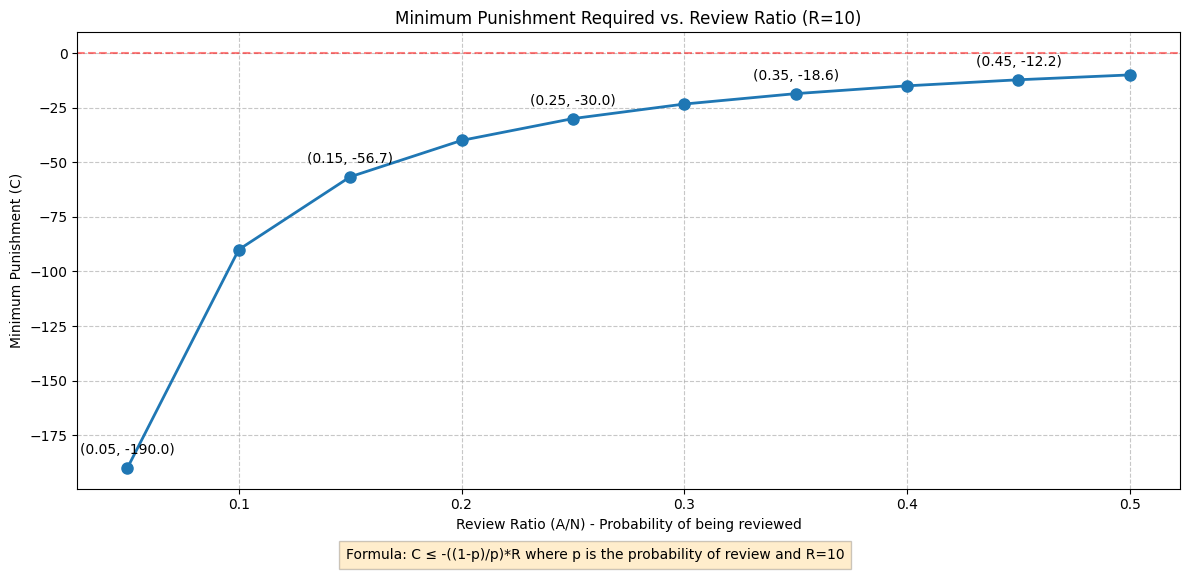

=== KEY INSIGHTS ===
1. As the review ratio (A/N) increases, the minimum punishment decreases in magnitude
2. When very few students are reviewed (low A/N), the punishment needs to be severe
3. The formula for minimum punishment is: C ≤ -((1-p)/p)*R where p is A/N and R=10
4. A higher review probability allows for a more moderate punishment policy


,Review Ratio (A/N),Minimum Punishment (C),Example Scenario
0,0.05,-190.00,5% chance of review → punishment of -190.0 points
1,0.10,-90.00,10% chance of review → punishment of -90.0 points
2,0.15,-56.67,15% chance of review → punishment of -56.7 points
3,0.20,-40.00,20% chance of review → punishment of -40.0 points
4,0.25,-30.00,25% chance of review → punishment of -30.0 points
5,0.30,-23.33,30% chance of review → punishment of -23.3 points
6,0.35,-18.57,35% chance of review → punishment of -18.6 points
7,0.40,-15.00,40% chance of review → punishment of -15.0 points
8,0.45,-12.22,45% chance of review → punishment of -12.2 points
9,0.50,-10.00,50% chance of review → punishment of -10.0 points


In [15]:
# Define parameters for the punishment vs review ratio simulation
R = 10  # Reward for completing homework

# Define A/N ratios to explore (from 5% to 50% chance of being reviewed)
A_N_ratios = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

# Run the visualization
visualize_punishment_vs_review_ratio(A_N_ratios, R)

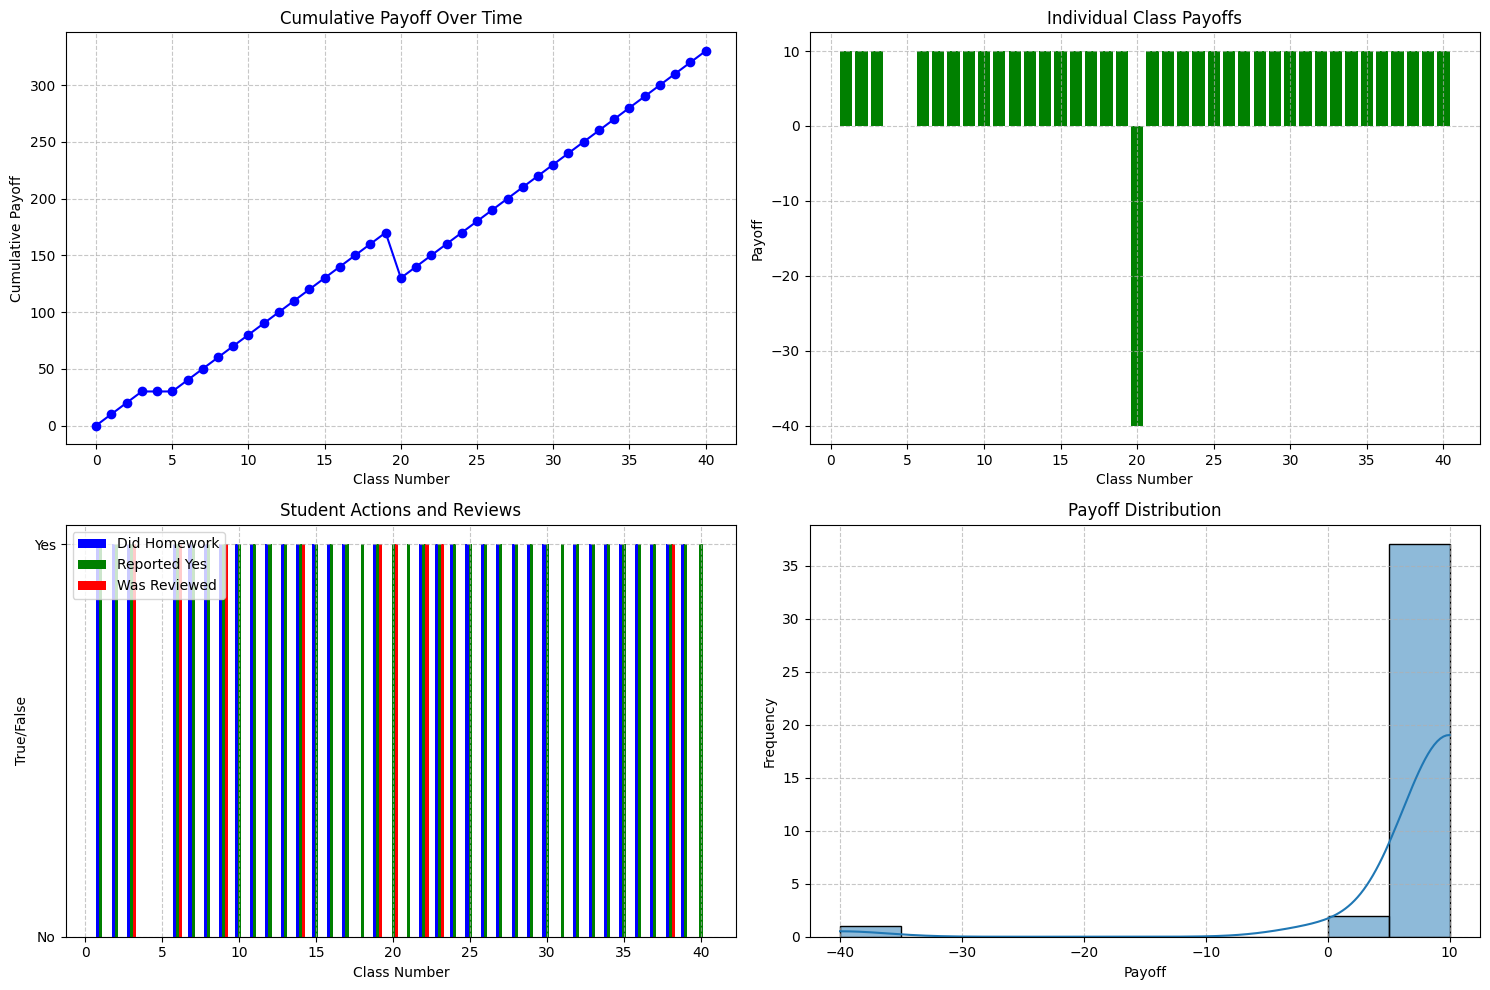

=== SIMULATION SUMMARY ===
Total number of students (N): 30
Students reviewed per class (A): 6
Probability of review (p): 0.20
Reward for homework (R): 10
Optimal punishment (C): -40.00
Applied punishment (C × 1.00): -40.00
Number of classes: 40
Student profile: 80% chance to do homework, 70% chance to lie when homework not done

=== RESULTS ===
Final grade (total payoff): 330.00
Average payoff per class: 8.25
Number of times homework completed: 33 (82%)
Number of times reported 'Yes': 38 (95%)
Number of times reviewed: 9 (22%)
Number of times lied: 5 (12% of all classes)
Number of times caught lying: 1 (20% of lies)


{'N': 30,
 'A': 6,
 'R': 10,
 'C': -40.0,
 'homework_prob': 0.8,
 'lie_prob': 0.7,
 'total_payoff': 330.0,
 'avg_payoff': 8.25,
 'results_df':     Class  Did Homework  Reported Yes  Was Reviewed  Payoff
 0       1          True          True         False    10.0
 1       2          True          True         False    10.0
 2       3          True          True          True    10.0
 3       4         False         False         False     0.0
 4       5         False         False         False     0.0
 5       6          True          True          True    10.0
 6       7          True          True         False    10.0
 7       8          True          True         False    10.0
 8       9          True          True          True    10.0
 9      10          True          True         False    10.0
 10     11          True          True         False    10.0
 11     12          True          True         False    10.0
 12     13          True          True         False    10.0
 13 

In [25]:
# Define parameters for simulating 40 classes for a single student profile
N = 30  # Total number of students
A = 6   # Number of students reviewed each class
R = 10  # Reward for completing homework
num_classes = 40  # Number of classes to simulate
penalty_multiplier = 1.0  # Multiplier for the punishment (1.0 = optimal)

# Define student profile
homework_prob = 0.8  # 80% chance of doing homework each class
lie_prob = 0.7      # 70% chance of lying when homework not done

# Run the simulation
simulate_classes_with_profile(
    N, A, R, num_classes, 
    homework_prob, lie_prob, 
    penalty_multiplier=penalty_multiplier
)

In [ ]:
# Define parameters for multiple profile simulations
N = 30  # Total number of students
A = 6   # Number of students reviewed each class
R = 10  # Reward for completing homework
num_classes = 40  # Number of classes per simulation
num_iterations = 100  # Number of iterations to run for each profile
penalty_multiplier = 5.0  # Multiplier for the punishment (1.0 = optimal)

# Define different student profiles to analyze
profiles = [
    {'name': 'Diligent', 'homework_prob': 1.0, 'lie_prob': 0.0},    # Always does homework, never lies
    {'name': 'Mostly Good', 'homework_prob': 0.8, 'lie_prob': 0.2}, # Usually does homework, rarely lies
    {'name': 'Average', 'homework_prob': 0.5, 'lie_prob': 0.5},     # 50/50 on homework, lies half the time
    {'name': 'Strategic', 'homework_prob': 0.3, 'lie_prob': 0.8},   # Rarely does homework, usually lies
    {'name': 'Slacker', 'homework_prob': 0.1, 'lie_prob': 1.0}      # Almost never does homework, always lies
]

# Run the multiple profile simulations
run_multiple_profile_simulations(
    N, A, R, num_classes, num_iterations, profiles,
    penalty_multiplier=penalty_multiplier
)

/tmp/ipykernel_82289/1861553817.py:387: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0, 1].boxplot(boxplot_data, labels=profile_names)
